In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import albumentations as A
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import sys
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import collections
from torchvision import datasets, models, transforms


In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
4# data_dir = '/content/drive/MyDrive/НТИ ИИ /data_team/'
project_dir = '/content/drive/MyDrive/НТИ ИИ /'
data_dir = 'data'
train_images = 'data/train_recognition/images'
image_size = 256
first_size = 512

# Settings

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection && pip install -e . && python setup.py develop

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
     |████████████████████████████████| 46.0 MB 4.4 MB/s 
     |████████████████████████████████| 190 kB 29.2 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 23446, done.
remote: Total 23446 (delta 0), reused 0 (delta 0), pack-reused 23446
Receiving objects: 100% (23446/23446), 26.05 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (16379/16379), done.
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet
running develop
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja a

In [ ]:
!unzip -q '/content/drive/MyDrive/НТИ ИИ /data_team/data_final.zip'

In [ ]:
# !git clone https://bitbucket.org/william_rusnack/minimumboundingbox.git
# sys.path.append('minimumboundingbox')

In [ ]:
!pip install transformers -q
!pip install -q datasets jiwer
!pip install sentencepiece -q

     |████████████████████████████████| 3.5 MB 28.9 MB/s 
     |████████████████████████████████| 6.5 MB 58.8 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 895 kB 70.2 MB/s 
     |████████████████████████████████| 311 kB 17.4 MB/s 
     |████████████████████████████████| 134 kB 51.0 MB/s 
     |████████████████████████████████| 212 kB 56.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 144 kB 47.7 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 51.3 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 


# Building datasets

In [ ]:
annotation = pd.read_csv('data/train_recognition/labels.csv')
annotation.head(10)

file_name       text base_image
0     0.png    дверку,    1_5.JPG
1     1.png     открыл    1_5.JPG
2     2.png          Я    1_5.JPG
3     3.png   хвостом.    1_5.JPG
4     4.png      вилял    1_5.JPG
5     5.png          и    1_5.JPG
6     6.png      рядом    1_5.JPG
7     7.png   крутился    1_5.JPG
8     8.png      Рыжик    1_5.JPG
9     9.png  вареньем.    1_5.JPG

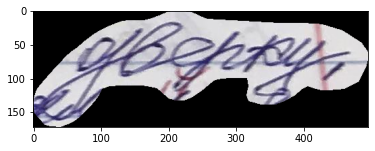

In [ ]:
image = plt.imread(os.path.join(train_images, '0.png'))
plt.imshow(image)
plt.show()

In [ ]:
len(os.listdir(train_images))

161700

In [ ]:
import json

with open(data_dir+'/train_segmentation/annotations.json') as f:
    seg_annotations = json.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

val_annot = seg_annotations.copy()
train_annot = seg_annotations.copy()

train_annot['images'], val_annot['images']  = train_test_split(seg_annotations['images'], test_size=0.1, random_state=42)

In [ ]:
with open(os.path.join(data_dir, 'train_segmentation/annotations_val.json'), 'w') as outfile:
    json.dump(val_annot, outfile)
    
    
with open(os.path.join(data_dir, 'train_segmentation/annotations_train.json'), 'w') as outfile:
    json.dump(train_annot, outfile)

# Train mask rcnn

## Train mask-rcnn

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes = 2):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
model = get_instance_segmentation_model()
model = model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=3e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.5)

Epoch 0/29
----------


100%|██████████| 98/98 [07:07<00:00,  4.36s/it]


train Loss: {'loss_box_reg': 0.055319822317845116, 'loss_rpn_box_reg': 0.02571481348349781, 'loss_objectness': 0.016485191162488637, 'loss_classifier': 0.03250909423122381, 'loss_mask': 0.03872861110028766, 'loss': 0.16875753301451105} 


100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


test Loss: {'loss_box_reg': 0.05034880357227106, 'loss_rpn_box_reg': 0.022726718036607765, 'loss_objectness': 0.010843117860541946, 'loss_classifier': 0.027398518618495984, 'loss_mask': 0.035525876900245404, 'loss': 0.14684303601582846} 
updated best loss, now it 0.14684303601582846


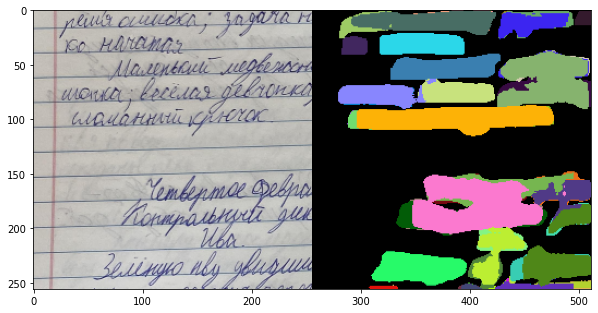


Epoch 1/29
----------


100%|██████████| 98/98 [07:09<00:00,  4.38s/it]


train Loss: {'loss_box_reg': 0.052665821872315964, 'loss_rpn_box_reg': 0.024145299182818818, 'loss_objectness': 0.014305449887975916, 'loss_classifier': 0.030986611293856547, 'loss_mask': 0.037385125590567427, 'loss': 0.15948830907409256} 


100%|██████████| 11/11 [00:50<00:00,  4.62s/it]


test Loss: {'loss_box_reg': 0.04564467586320022, 'loss_rpn_box_reg': 0.024281169405613822, 'loss_objectness': 0.009335646470045221, 'loss_classifier': 0.0246910125702277, 'loss_mask': 0.03573766145212897, 'loss': 0.13969016486200794} 
updated best loss, now it 0.13969016486200794


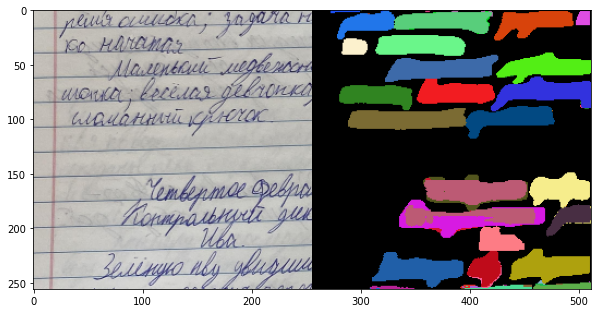


Epoch 2/29
----------


100%|██████████| 98/98 [07:11<00:00,  4.41s/it]


train Loss: {'loss_box_reg': 0.04881557480862395, 'loss_rpn_box_reg': 0.02326397241082431, 'loss_objectness': 0.012506555439844401, 'loss_classifier': 0.029479092938712818, 'loss_mask': 0.03616494247198412, 'loss': 0.15023013723096026} 


100%|██████████| 11/11 [00:51<00:00,  4.66s/it]


test Loss: {'loss_box_reg': 0.04809583398117416, 'loss_rpn_box_reg': 0.02306836021357569, 'loss_objectness': 0.009572063626229078, 'loss_classifier': 0.0282178301920836, 'loss_mask': 0.03549586801693357, 'loss': 0.14444995611563496} 


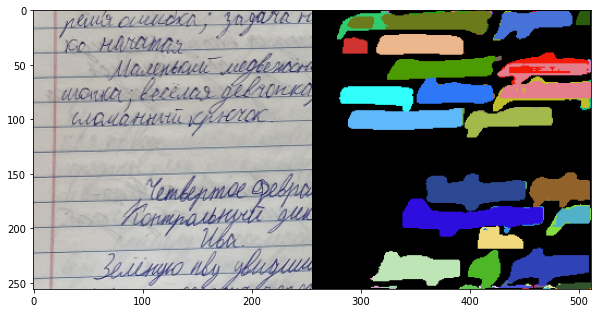


Epoch 3/29
----------


100%|██████████| 98/98 [07:02<00:00,  4.32s/it]


train Loss: {'loss_box_reg': 0.0492956560090702, 'loss_rpn_box_reg': 0.02416544082542184, 'loss_objectness': 0.01382577598114118, 'loss_classifier': 0.029268422258713376, 'loss_mask': 0.03640794564167965, 'loss': 0.15296324009754175} 


100%|██████████| 11/11 [00:51<00:00,  4.67s/it]


test Loss: {'loss_box_reg': 0.047859290893050445, 'loss_rpn_box_reg': 0.025811151868995578, 'loss_objectness': 0.009525972022407356, 'loss_classifier': 0.025483325637620072, 'loss_mask': 0.03408505365081217, 'loss': 0.14276479578566278} 


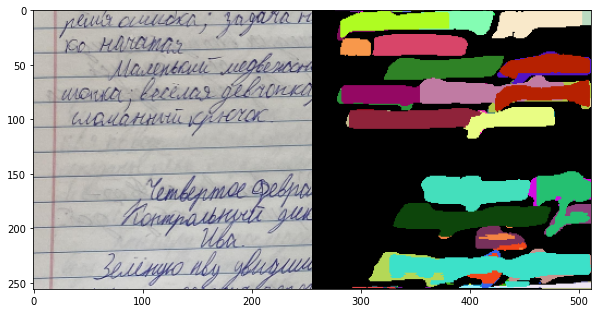


Epoch 4/29
----------


100%|██████████| 98/98 [07:07<00:00,  4.36s/it]


train Loss: {'loss_box_reg': 0.047793913110035884, 'loss_rpn_box_reg': 0.02173582811574985, 'loss_objectness': 0.013995485771039892, 'loss_classifier': 0.028154092444109335, 'loss_mask': 0.03574796492758865, 'loss': 0.1474272845027683} 


100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


test Loss: {'loss_box_reg': 0.042133816699872075, 'loss_rpn_box_reg': 0.02219282784338655, 'loss_objectness': 0.008780789358177405, 'loss_classifier': 0.022595716790221203, 'loss_mask': 0.03226157235003066, 'loss': 0.1279647220140216} 
updated best loss, now it 0.1279647220140216


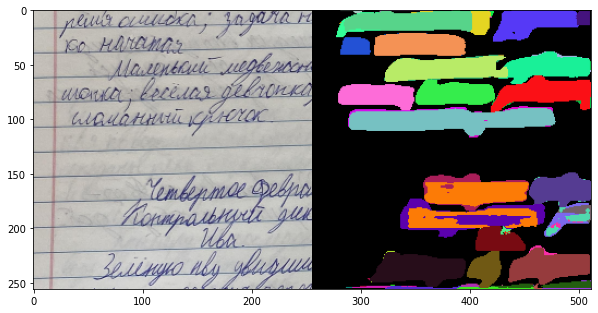


Epoch 5/29
----------


100%|██████████| 98/98 [07:14<00:00,  4.44s/it]


train Loss: {'loss_box_reg': 0.047070525826327744, 'loss_rpn_box_reg': 0.022443128320624624, 'loss_objectness': 0.012457418995052384, 'loss_classifier': 0.028145353862370916, 'loss_mask': 0.03557572539708789, 'loss': 0.14569215240625802} 


100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


test Loss: {'loss_box_reg': 0.04301285709457836, 'loss_rpn_box_reg': 0.020370569808044654, 'loss_objectness': 0.006394666416206579, 'loss_classifier': 0.02397671410407143, 'loss_mask': 0.033684097316073275, 'loss': 0.127438904910252} 
updated best loss, now it 0.127438904910252


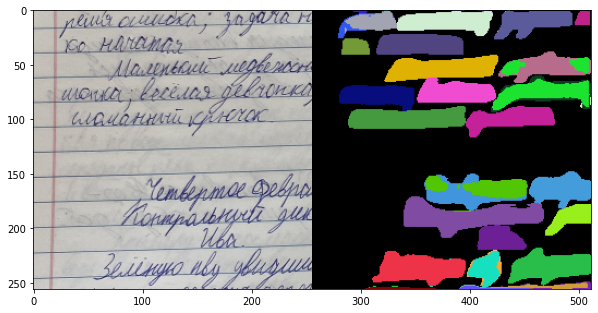


Epoch 6/29
----------


100%|██████████| 98/98 [07:14<00:00,  4.44s/it]


train Loss: {'loss_box_reg': 0.04575317910125664, 'loss_rpn_box_reg': 0.022917036892441095, 'loss_objectness': 0.011846182386042068, 'loss_classifier': 0.026840287381771143, 'loss_mask': 0.035134324504295066, 'loss': 0.14249101024183375} 


100%|██████████| 11/11 [00:52<00:00,  4.80s/it]


test Loss: {'loss_box_reg': 0.040546525141288495, 'loss_rpn_box_reg': 0.02440941068290294, 'loss_objectness': 0.007944999498197403, 'loss_classifier': 0.023157469500070332, 'loss_mask': 0.03234983483950297, 'loss': 0.12840824223112787} 


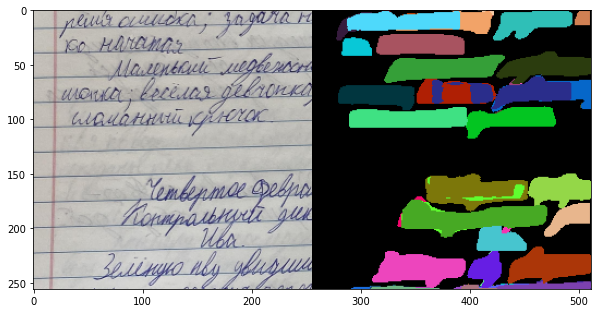


Epoch 7/29
----------


100%|██████████| 98/98 [07:06<00:00,  4.35s/it]


train Loss: {'loss_box_reg': 0.04508298635482788, 'loss_rpn_box_reg': 0.02182652699632841, 'loss_objectness': 0.011033067438976798, 'loss_classifier': 0.026673397636628366, 'loss_mask': 0.034656119757023866, 'loss': 0.13927209906596474} 


100%|██████████| 11/11 [00:52<00:00,  4.74s/it]


test Loss: {'loss_box_reg': 0.03885809494846169, 'loss_rpn_box_reg': 0.023140283836715524, 'loss_objectness': 0.007650450128933479, 'loss_classifier': 0.02099599218231508, 'loss_mask': 0.031324017664481854, 'loss': 0.12196883867526877} 
updated best loss, now it 0.12196883867526877


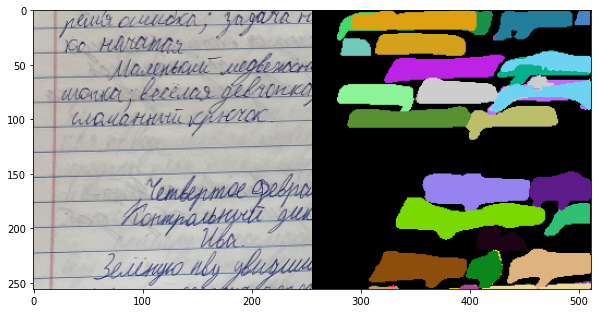


Epoch 8/29
----------


100%|██████████| 98/98 [07:13<00:00,  4.42s/it]


train Loss: {'loss_box_reg': 0.04490271003550084, 'loss_rpn_box_reg': 0.0206612677599856, 'loss_objectness': 0.011433351204815673, 'loss_classifier': 0.026638724072866306, 'loss_mask': 0.034413728762317346, 'loss': 0.13804978101563423} 


100%|██████████| 11/11 [00:52<00:00,  4.79s/it]


test Loss: {'loss_box_reg': 0.04294411718160256, 'loss_rpn_box_reg': 0.02426771853847065, 'loss_objectness': 0.008152713206992752, 'loss_classifier': 0.02617262971812281, 'loss_mask': 0.032523742009853494, 'loss': 0.1340609199699314} 


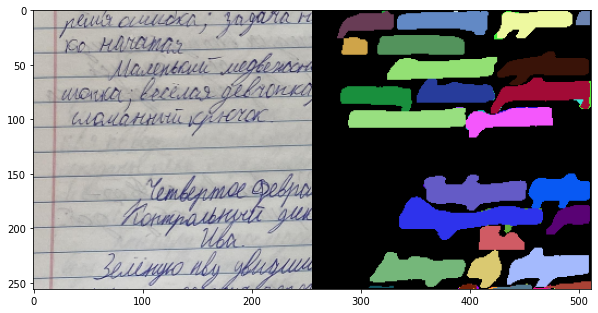


Epoch 9/29
----------


100%|██████████| 98/98 [07:04<00:00,  4.33s/it]


train Loss: {'loss_box_reg': 0.043183547074270065, 'loss_rpn_box_reg': 0.021797216460204646, 'loss_objectness': 0.010644313590445266, 'loss_classifier': 0.026272441256920805, 'loss_mask': 0.0341839062737989, 'loss': 0.1360814254563134} 


100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


test Loss: {'loss_box_reg': 0.038993656292728995, 'loss_rpn_box_reg': 0.021683999005405383, 'loss_objectness': 0.007638121644655864, 'loss_classifier': 0.023974253699697298, 'loss_mask': 0.03189520572108784, 'loss': 0.12418523602101994} 


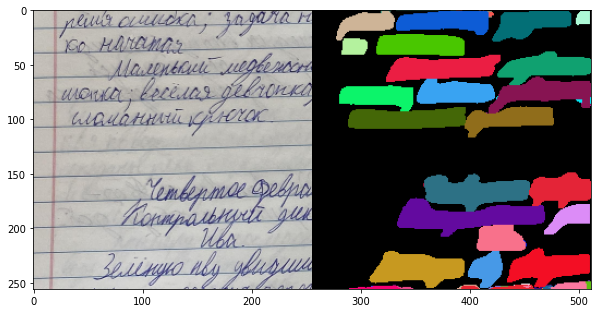


Epoch 10/29
----------


100%|██████████| 98/98 [07:13<00:00,  4.42s/it]


train Loss: {'loss_box_reg': 0.04339261665614262, 'loss_rpn_box_reg': 0.02209290737907092, 'loss_objectness': 0.010599503741914854, 'loss_classifier': 0.026560836508774235, 'loss_mask': 0.034020870693862205, 'loss': 0.1366667348599035} 


100%|██████████| 11/11 [00:50<00:00,  4.55s/it]


test Loss: {'loss_box_reg': 0.03875888010551189, 'loss_rpn_box_reg': 0.022205919626800494, 'loss_objectness': 0.007045804597865576, 'loss_classifier': 0.02242919854049025, 'loss_mask': 0.0315588416381814, 'loss': 0.12199864784876506} 


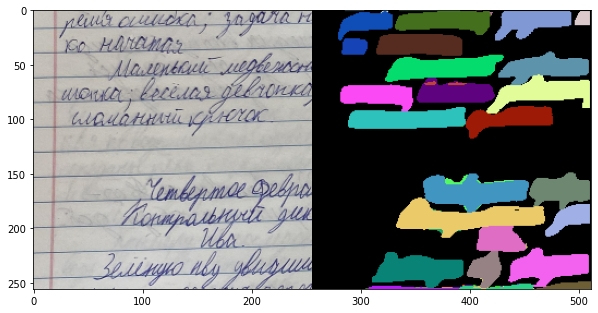


Epoch 11/29
----------


100%|██████████| 98/98 [07:09<00:00,  4.39s/it]


train Loss: {'loss_box_reg': 0.043110349166423964, 'loss_rpn_box_reg': 0.019898837357351946, 'loss_objectness': 0.009854560950471321, 'loss_classifier': 0.026208262415926428, 'loss_mask': 0.034211227658325793, 'loss': 0.13328323753950985} 


100%|██████████| 11/11 [00:51<00:00,  4.67s/it]


test Loss: {'loss_box_reg': 0.0392831046690886, 'loss_rpn_box_reg': 0.018821402442181247, 'loss_objectness': 0.006416514258960198, 'loss_classifier': 0.022687444227865373, 'loss_mask': 0.031751189252425885, 'loss': 0.11895965502179902} 
updated best loss, now it 0.11895965502179902


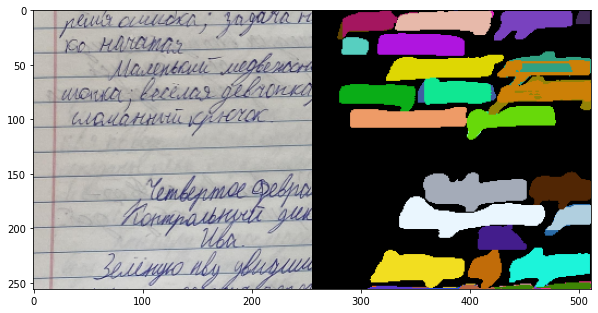


Epoch 12/29
----------


100%|██████████| 98/98 [07:13<00:00,  4.43s/it]


train Loss: {'loss_box_reg': 0.043420676827584145, 'loss_rpn_box_reg': 0.023590284002947225, 'loss_objectness': 0.011194673317701506, 'loss_classifier': 0.026299881294580652, 'loss_mask': 0.03411664791702457, 'loss': 0.13862216288518722} 


100%|██████████| 11/11 [00:50<00:00,  4.57s/it]


test Loss: {'loss_box_reg': 0.03938793999025191, 'loss_rpn_box_reg': 0.02206906265225904, 'loss_objectness': 0.005745624973513614, 'loss_classifier': 0.02305621199909298, 'loss_mask': 0.03189135642572381, 'loss': 0.12215019437088363} 


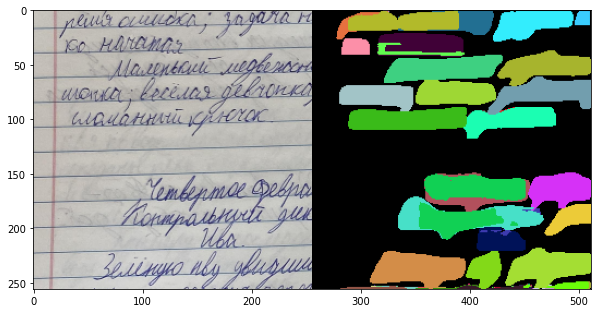


Epoch 13/29
----------


100%|██████████| 98/98 [07:11<00:00,  4.41s/it]


train Loss: {'loss_box_reg': 0.044185517108885325, 'loss_rpn_box_reg': 0.022925821683121465, 'loss_objectness': 0.011320347059877682, 'loss_classifier': 0.026538405658502223, 'loss_mask': 0.03446840541856783, 'loss': 0.13943849728374408} 


100%|██████████| 11/11 [00:50<00:00,  4.57s/it]


test Loss: {'loss_box_reg': 0.038274581062382663, 'loss_rpn_box_reg': 0.01889086146464293, 'loss_objectness': 0.006374284475185405, 'loss_classifier': 0.023058443233884614, 'loss_mask': 0.03154920435499871, 'loss': 0.11814737662501719} 
updated best loss, now it 0.11814737662501719


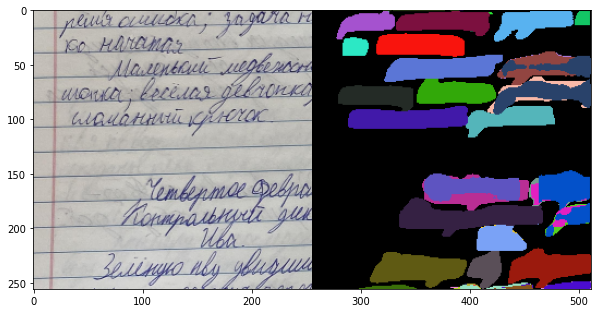


Epoch 14/29
----------


100%|██████████| 98/98 [07:09<00:00,  4.38s/it]


train Loss: {'loss_box_reg': 0.042434449399913754, 'loss_rpn_box_reg': 0.02116889914106985, 'loss_objectness': 0.010795054135021862, 'loss_classifier': 0.025263622882590177, 'loss_mask': 0.03379144512855255, 'loss': 0.13345347047619224} 


100%|██████████| 11/11 [00:49<00:00,  4.52s/it]


test Loss: {'loss_box_reg': 0.037050776783077194, 'loss_rpn_box_reg': 0.018806712466409838, 'loss_objectness': 0.006603380943509354, 'loss_classifier': 0.020168026117072708, 'loss_mask': 0.031570598996918775, 'loss': 0.1141994965487513} 
updated best loss, now it 0.1141994965487513


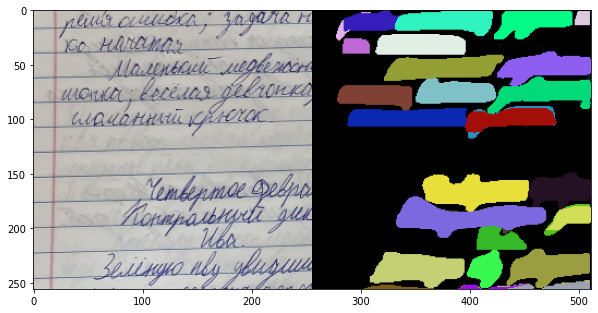


Epoch 15/29
----------


100%|██████████| 98/98 [07:20<00:00,  4.50s/it]


train Loss: {'loss_box_reg': 0.04286683833123481, 'loss_rpn_box_reg': 0.02153015062404722, 'loss_objectness': 0.010846014883719203, 'loss_classifier': 0.025756986291558894, 'loss_mask': 0.033636013551721855, 'loss': 0.1346360038452934} 


100%|██████████| 11/11 [00:51<00:00,  4.73s/it]


test Loss: {'loss_box_reg': 0.03776609846230211, 'loss_rpn_box_reg': 0.022168673146730183, 'loss_objectness': 0.0072931364264296385, 'loss_classifier': 0.02166046887293629, 'loss_mask': 0.03169489061010295, 'loss': 0.1205832663623766} 


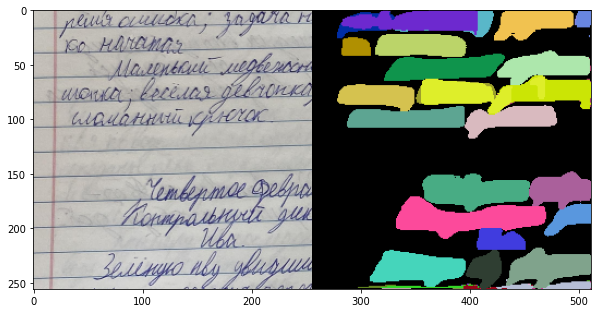


Epoch 16/29
----------


100%|██████████| 98/98 [07:13<00:00,  4.42s/it]


train Loss: {'loss_box_reg': 0.042908581642570644, 'loss_rpn_box_reg': 0.020957546306239437, 'loss_objectness': 0.010619892241334977, 'loss_classifier': 0.026145367989822397, 'loss_mask': 0.03399861148502222, 'loss': 0.13462999988553453} 


100%|██████████| 11/11 [00:51<00:00,  4.71s/it]


test Loss: {'loss_box_reg': 0.0405304486724152, 'loss_rpn_box_reg': 0.026944147273041737, 'loss_objectness': 0.0072554233858640165, 'loss_classifier': 0.022721958057633763, 'loss_mask': 0.03190516534892992, 'loss': 0.1293571426950652} 


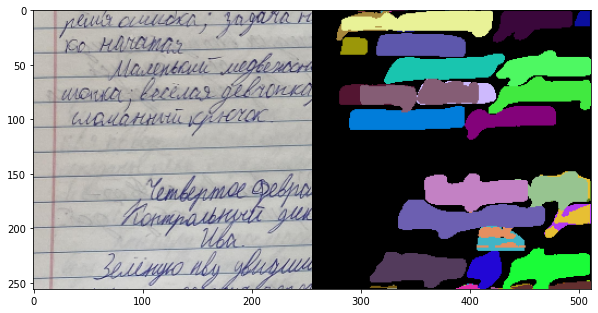


Epoch 17/29
----------


100%|██████████| 98/98 [07:07<00:00,  4.37s/it]


train Loss: {'loss_box_reg': 0.0420484176166883, 'loss_rpn_box_reg': 0.019608918726060687, 'loss_objectness': 0.010340639537480807, 'loss_classifier': 0.024885876797034166, 'loss_mask': 0.033583602619907574, 'loss': 0.13046745551292194} 


100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


test Loss: {'loss_box_reg': 0.039880712827046715, 'loss_rpn_box_reg': 0.01955511545141538, 'loss_objectness': 0.007532269875893648, 'loss_classifier': 0.020956694394692606, 'loss_mask': 0.03157825408310726, 'loss': 0.11950304727444704} 


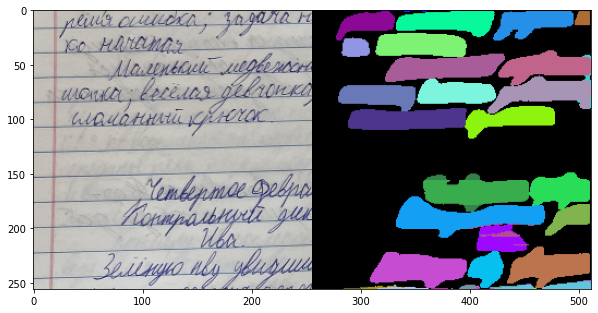


Epoch 18/29
----------


100%|██████████| 98/98 [07:15<00:00,  4.45s/it]


train Loss: {'loss_box_reg': 0.041806485873084887, 'loss_rpn_box_reg': 0.020043085200982972, 'loss_objectness': 0.010069138889453893, 'loss_classifier': 0.02449381328457571, 'loss_mask': 0.033088255055162434, 'loss': 0.1295007778717591} 


100%|██████████| 11/11 [00:50<00:00,  4.55s/it]


test Loss: {'loss_box_reg': 0.03958915328157359, 'loss_rpn_box_reg': 0.018663761345134384, 'loss_objectness': 0.006918542001439237, 'loss_classifier': 0.02233411885541061, 'loss_mask': 0.03078932563463847, 'loss': 0.11829490017616885} 


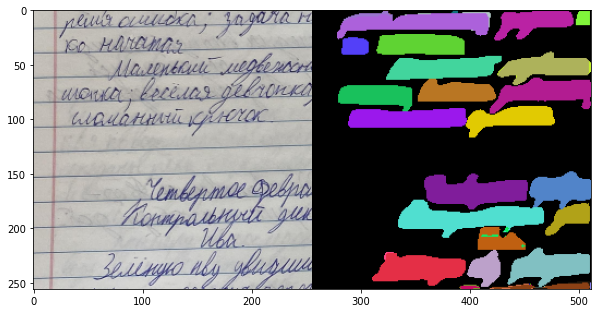


Epoch 19/29
----------


100%|██████████| 98/98 [07:15<00:00,  4.44s/it]


train Loss: {'loss_box_reg': 0.03930886774449735, 'loss_rpn_box_reg': 0.019266858183931045, 'loss_objectness': 0.009069740261638027, 'loss_classifier': 0.024316896323685173, 'loss_mask': 0.03204898089362234, 'loss': 0.12401134358716594} 


100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


test Loss: {'loss_box_reg': 0.03401235619495655, 'loss_rpn_box_reg': 0.017266671034111374, 'loss_objectness': 0.006505070639581516, 'loss_classifier': 0.02040674528856387, 'loss_mask': 0.029731226035918313, 'loss': 0.10792206758740304} 
updated best loss, now it 0.10792206758740304


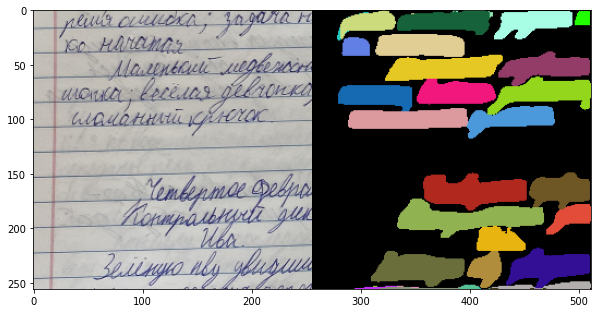


Epoch 20/29
----------


100%|██████████| 98/98 [07:18<00:00,  4.48s/it]


train Loss: {'loss_box_reg': 0.0385802779035065, 'loss_rpn_box_reg': 0.02178393025071081, 'loss_objectness': 0.009327917063711846, 'loss_classifier': 0.023369405643973724, 'loss_mask': 0.03199440212093265, 'loss': 0.1250559326304432} 


100%|██████████| 11/11 [00:51<00:00,  4.71s/it]


test Loss: {'loss_box_reg': 0.03531807900845319, 'loss_rpn_box_reg': 0.018431900904096406, 'loss_objectness': 0.005533524242968395, 'loss_classifier': 0.020069353368090487, 'loss_mask': 0.03018080263302244, 'loss': 0.10953366071328349} 


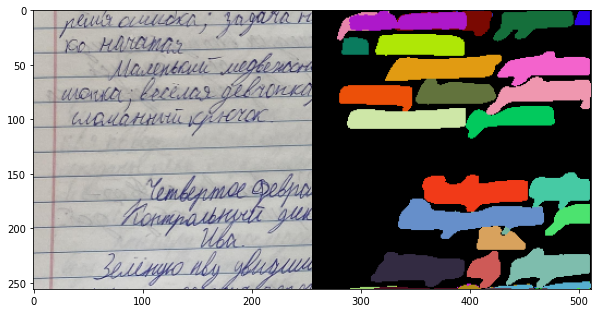


Epoch 21/29
----------


100%|██████████| 98/98 [07:11<00:00,  4.41s/it]


train Loss: {'loss_box_reg': 0.03799478489152867, 'loss_rpn_box_reg': 0.01901788888271404, 'loss_objectness': 0.00851460358312538, 'loss_classifier': 0.02290573700821384, 'loss_mask': 0.031568281400464526, 'loss': 0.12000129535851792} 


100%|██████████| 11/11 [00:52<00:00,  4.73s/it]


test Loss: {'loss_box_reg': 0.033997818656351375, 'loss_rpn_box_reg': 0.020046460559998435, 'loss_objectness': 0.006130615399144162, 'loss_classifier': 0.02021904443872386, 'loss_mask': 0.02878893654921959, 'loss': 0.10918287710211742} 


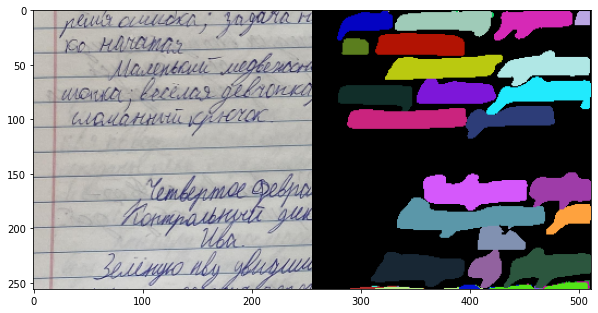


Epoch 22/29
----------


100%|██████████| 98/98 [07:08<00:00,  4.37s/it]


train Loss: {'loss_box_reg': 0.03821444152788459, 'loss_rpn_box_reg': 0.020551698951187282, 'loss_objectness': 0.008954354467174875, 'loss_classifier': 0.022579628000925254, 'loss_mask': 0.031712828973545534, 'loss': 0.12201295265666613} 


100%|██████████| 11/11 [00:50<00:00,  4.57s/it]


test Loss: {'loss_box_reg': 0.033815984582078865, 'loss_rpn_box_reg': 0.01590232679556156, 'loss_objectness': 0.005823424835314696, 'loss_classifier': 0.01896244715685132, 'loss_mask': 0.030216749543431162, 'loss': 0.1047209323137656} 
updated best loss, now it 0.1047209323137656


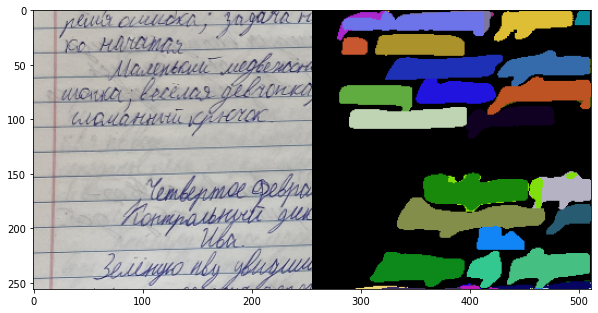


Epoch 23/29
----------


100%|██████████| 98/98 [07:10<00:00,  4.39s/it]


train Loss: {'loss_box_reg': 0.037542441119098297, 'loss_rpn_box_reg': 0.019415161290722616, 'loss_objectness': 0.008088681890007152, 'loss_classifier': 0.022393864659805862, 'loss_mask': 0.031375587715298664, 'loss': 0.11881573726465036} 


100%|██████████| 11/11 [00:51<00:00,  4.67s/it]


test Loss: {'loss_box_reg': 0.03486272829702531, 'loss_rpn_box_reg': 0.02114347368478775, 'loss_objectness': 0.006454295682153483, 'loss_classifier': 0.020276609679748273, 'loss_mask': 0.03013039183342594, 'loss': 0.11286749990507104} 


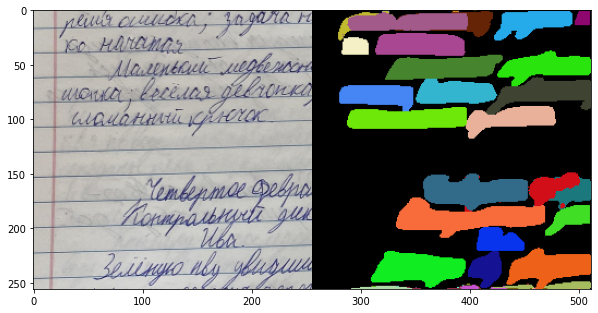


Epoch 24/29
----------


100%|██████████| 98/98 [07:09<00:00,  4.38s/it]


train Loss: {'loss_box_reg': 0.03723092411705886, 'loss_rpn_box_reg': 0.0192028054802114, 'loss_objectness': 0.007675637633682371, 'loss_classifier': 0.022294169668218497, 'loss_mask': 0.031700877091599244, 'loss': 0.11810441443665454} 


100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


test Loss: {'loss_box_reg': 0.03367555364110004, 'loss_rpn_box_reg': 0.017329846176950412, 'loss_objectness': 0.005048744551751806, 'loss_classifier': 0.019731271284065027, 'loss_mask': 0.029480411746036047, 'loss': 0.10526582632941761} 


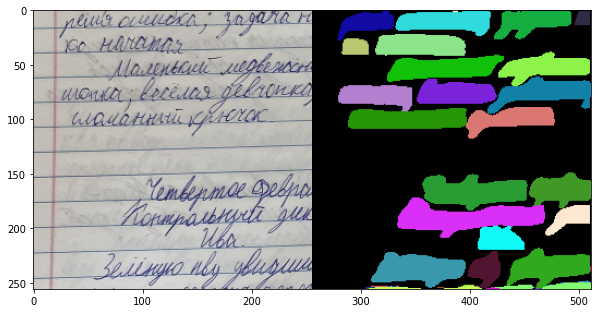


Epoch 25/29
----------


100%|██████████| 98/98 [07:10<00:00,  4.39s/it]


train Loss: {'loss_box_reg': 0.03698884775356283, 'loss_rpn_box_reg': 0.019292059470749575, 'loss_objectness': 0.007851967993198367, 'loss_classifier': 0.022208460931458836, 'loss_mask': 0.031802053809012534, 'loss': 0.11814339058126108} 


100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


test Loss: {'loss_box_reg': 0.03333815932273865, 'loss_rpn_box_reg': 0.019473762090863853, 'loss_objectness': 0.005839560994471626, 'loss_classifier': 0.019241536657015484, 'loss_mask': 0.030020048049674636, 'loss': 0.10791306454559853} 


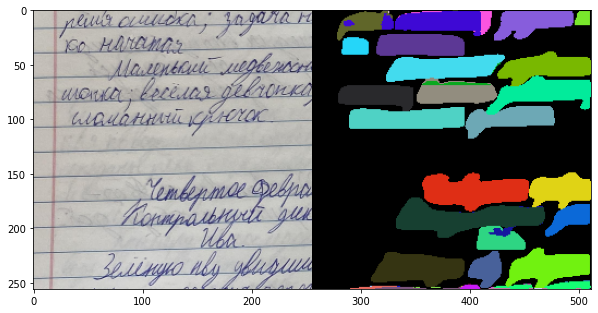


Epoch 26/29
----------


100%|██████████| 98/98 [07:12<00:00,  4.41s/it]


train Loss: {'loss_box_reg': 0.036987442499268774, 'loss_rpn_box_reg': 0.018462114971001635, 'loss_objectness': 0.0074985579802070955, 'loss_classifier': 0.021901225635213743, 'loss_mask': 0.03141806641907612, 'loss': 0.11626740733935872} 


100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


test Loss: {'loss_box_reg': 0.03392487730102978, 'loss_rpn_box_reg': 0.021194464858921094, 'loss_objectness': 0.004567273560611681, 'loss_classifier': 0.019816652968012053, 'loss_mask': 0.029816252746801268, 'loss': 0.1093195217779313} 


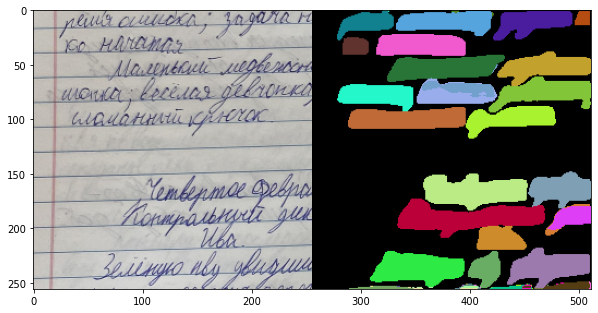


Epoch 27/29
----------


100%|██████████| 98/98 [07:12<00:00,  4.42s/it]


train Loss: {'loss_box_reg': 0.03690055758719892, 'loss_rpn_box_reg': 0.019074831949007557, 'loss_objectness': 0.008310036767307703, 'loss_classifier': 0.021814293123810446, 'loss_mask': 0.031378776026815366, 'loss': 0.11747849532229253} 


100%|██████████| 11/11 [00:51<00:00,  4.64s/it]


test Loss: {'loss_box_reg': 0.03332319050684743, 'loss_rpn_box_reg': 0.017599817322588515, 'loss_objectness': 0.004707579597316939, 'loss_classifier': 0.019515250863014966, 'loss_mask': 0.029530399489676815, 'loss': 0.10467623773662524} 
updated best loss, now it 0.10467623773662524


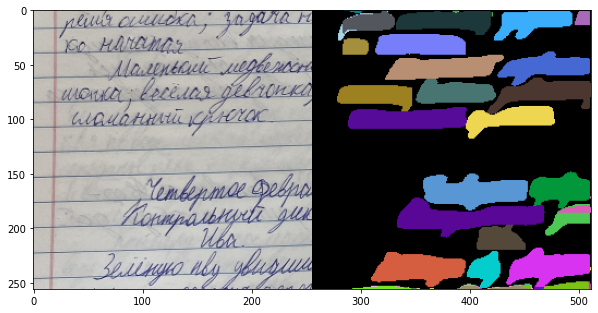


Epoch 28/29
----------


100%|██████████| 98/98 [07:20<00:00,  4.49s/it]


train Loss: {'loss_box_reg': 0.037260562123939335, 'loss_rpn_box_reg': 0.018775195540186675, 'loss_objectness': 0.008160187909559394, 'loss_classifier': 0.021948492080165, 'loss_mask': 0.031584578706490944, 'loss': 0.1177290161757549} 


100%|██████████| 11/11 [00:50<00:00,  4.59s/it]


test Loss: {'loss_box_reg': 0.03373359777461523, 'loss_rpn_box_reg': 0.014517146837094734, 'loss_objectness': 0.0045796733178283975, 'loss_classifier': 0.01901725636816573, 'loss_mask': 0.030231834314335352, 'loss': 0.10207951000367088} 
updated best loss, now it 0.10207951000367088


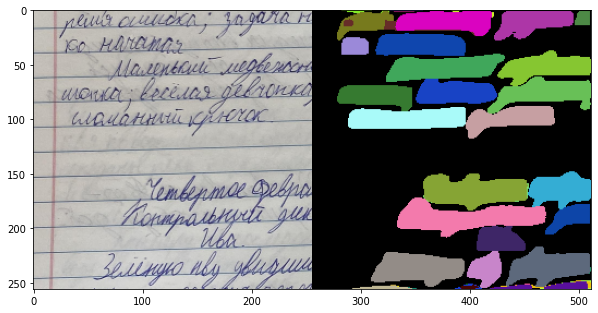


Epoch 29/29
----------


100%|██████████| 98/98 [07:13<00:00,  4.42s/it]


train Loss: {'loss_box_reg': 0.03691133877868971, 'loss_rpn_box_reg': 0.020962328121468827, 'loss_objectness': 0.008431319080226056, 'loss_classifier': 0.021875101703781267, 'loss_mask': 0.03121446730854275, 'loss': 0.119394554901614} 


100%|██████████| 11/11 [00:52<00:00,  4.80s/it]


test Loss: {'loss_box_reg': 0.03385329366415397, 'loss_rpn_box_reg': 0.020666296112126316, 'loss_objectness': 0.005796055470047326, 'loss_classifier': 0.020040677539233505, 'loss_mask': 0.028991070286980992, 'loss': 0.10934739345791696} 


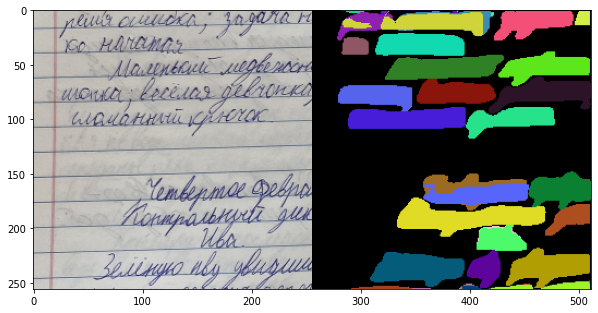

In [ ]:
history = train_model(model, train_loader, val_loader, None, optimizer, lr_scheduler, 30, 'mask_rcnn_small_2')

# Generate poligons

### Get masks

In [ ]:
sys.path.append('mmdetection')

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot, set_random_seed

In [ ]:
class SegmentationModel:
  def __init__(self, model_path, cfg):
    with open('labels.txt', 'w') as f:
      f.write('text')
    self.cfg = cfg
    self.cfg.load_from = model_path
    self.model = init_detector(self.cfg, model_path, device=device)
    self.model.CLASSES = ['text']
    self.model.cfg = self.cfg
    self.threshold = 0.3

  def eval(self):
    return self
 
  def __call__(self, batch):
    result = mmdet.apis.inference.inference_detector(self.model, batch)
    output = []
    for img in result:
      out_img = []
      for box in img[0]:
        out = []
        #print(len(box))
        left, top, right, bottom, c = box
        if c > self.threshold:
          out.append([[left, top]])
          out.append([[right, top]])
          out.append([[right, bottom]])
          out.append([[left, bottom]])
          out_img.append(out)
      output.append(out_img)
    return np.array(output).astype(int)

In [ ]:
import config
importlib.reload(config)

seg_model = SegmentationModel('/content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth',
                              config.cfg)

load checkpoint from local path: /content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth


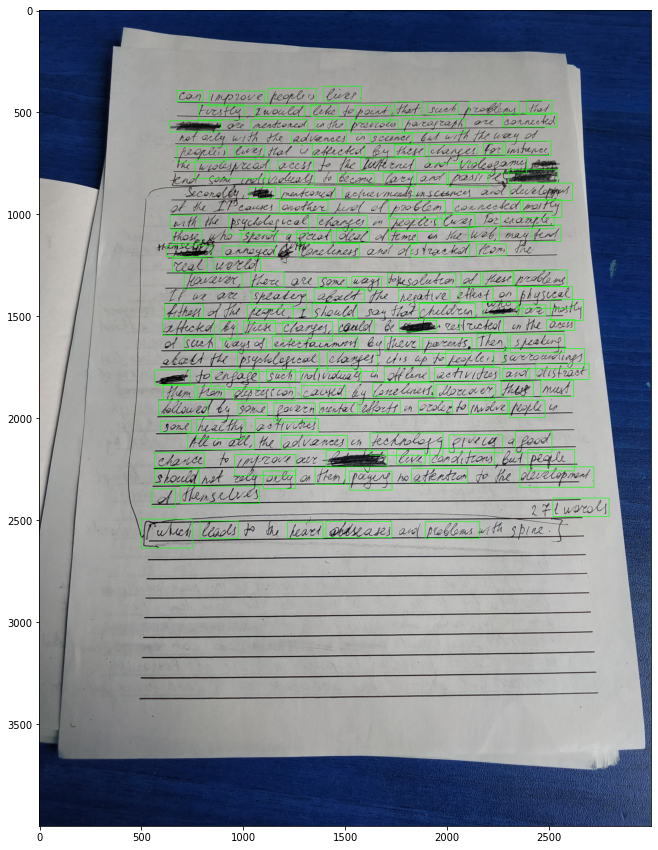

In [ ]:
image = cv2.imread('data/train_segmentation/images/0_0_eng.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

contours = seg_model([image])

for contour in contours[0]:
    cv2.drawContours(image, np.array([contour.astype(int)]), -1, (0, 255, 0), 2)
    

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

# Loading TrOcr

In [ ]:
def plot_images(images_for_show):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.clip(images_for_show[i - 1], 0, 1))
    
  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [ ]:
class AlbuPadding(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(AlbuPadding, self).__init__(always_apply, p)

    def apply(self, image, **params):
        zeros = np.zeros((128, 384, 3))
        image = np.concatenate([zeros, image, zeros], axis=0)
        return image.astype(np.uint8)

In [ ]:
from albumentations.pytorch.transforms import ToTensor
from transformers import AutoFeatureExtractor, XLMRobertaTokenizer, VisionEncoderDecoderModel, RobertaTokenizer

class TrOcrModel:
  def __init__(self, model_path, padding=True):
      self.model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)
      self.model.eval()

      self.feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/trocr-small-handwritten')
      self.tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/trocr-small-handwritten')
      
      if padding:
        self.transforms = A.Compose([
                A.Resize(128, 384),
                AlbuPadding(always_apply=True),
            ])
      else:
        self.transforms = A.Compose([
                A.Resize(384, 384),
            ])
  
  def image_preprocess(self, image):
      image = self.transforms(image=image)['image']
      pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
      return pixel_values

  def predict_batch(self, images):
      batch = torch.concat([self.image_preprocess(image) for image in images], axis=0).to(device)
      outputs = self.model.generate(batch)
      return [self.tokenizer.decode(pred.cpu().numpy(), skip_special_tokens=True) for pred in outputs]

  def __call__(self, image):
      pred = self.model.generate(self.image_preprocess(image).to(device))
      return self.tokenizer.decode(pred[0].cpu().numpy(), skip_special_tokens=True)   

In [ ]:
text_model = TrOcrModel("/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small_aug_nti2data")

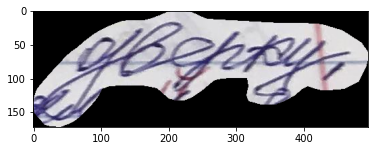

In [ ]:
image = cv2.imread(os.path.join(train_images, '0.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
text_model(image)

'дверку,'

In [ ]:
text_model.predict_batch([image, image])

['дверку,', 'дверку,']

# Making predict

In [ ]:
from PIL import ImageFont, ImageDraw, Image

In [ ]:
def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w]
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst

In [ ]:
def get_image_visualization(img, pred_data, fontpath, font_koef=50):
    img = img.copy()
    h, w = img.shape[:2]
    font = ImageFont.truetype(fontpath, int(h/font_koef))
    empty_img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(empty_img)

    for prediction in pred_data['predictions']:
        polygon = prediction['polygon']
        pred_text = prediction['text']
        cv2.drawContours(img, np.array([polygon]), -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(np.array([polygon]))
        draw.text((x, y), pred_text, fill=0, font=font)
        # print(pred_text, x, y)

    vis_img = np.array(empty_img)
    vis = np.concatenate((img, vis_img), axis=1)
    return vis

In [ ]:
def get_polygon_for_answer(polygon, croped):
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x1,y1,w,h = rect
    mid_x = x1 + w // 2
    mid_y = y1 + h // 2

    best = 1e9
    for i in range(h):
      now = abs((croped[:i, :] != [0, 0, 0]).sum() - (croped[i:, :] != [0, 0, 0]).sum())
      if now < best:
        best = now
        mid_y = i + y1

    x1 = mid_x - w // 5
    x2 = mid_x + w // 5
    # return [(mid_y, x1), (mid_y + 5, x1), (mid_y + 5, x2), (mid_y, x2)]
    return [(x1, mid_y), (x1, mid_y + 1), (x2, mid_y + 1), (x2, mid_y)]

In [ ]:
def get_classifier_model():

  model = models.resnet50(pretrained=True)
  model.fc = nn.Sequential(
      nn.Linear(2048, 256),
      nn.ReLU(),
      nn.Linear(256, 2)
  )
  return model

In [ ]:
with open(os.path.join(data_dir, 'train_segmentation/annotations.json'), 'r') as f:
    annotations = json.load(f)

def get_image_cer(image_name):
  img = cv2.imread('data/train_segmentation/images/' + image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred_data = {}
  pred_data[image_name] = pipeline_model(img)
  with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

  now = annotations.copy()
  for el in annotations['images']:
    if el['file_name'] == image_name:
      now['images'] = [el]
      break

  
  with open(os.path.join('annotations_now.json'), 'w') as outfile:
      json.dump(now, outfile)
  print('predict is ready')
  
  print(os.popen('python3 data/evaluate.py --ref_path annotations_now.json --pred_path prediction.json').read())

In [ ]:
np.argsort([0, 3, 2])

array([0, 2, 1])

In [ ]:
import config

class PiepleinePredictor:
    def __init__(self, segm_model_path, ru_ocr_model_path, en_ocr_model_path, classifier_model_path):
        # self.seg_model = SEGMpredictor(segm_model_path)
        self.seg_model = SegmentationModel(segm_model_path, config.cfg)

        self.text_model = {'ru': TrOcrModel(ru_ocr_model_path),
                           'en': TrOcrModel(en_ocr_model_path)}
        self.batch_size = 8
        self.transforms = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)

        self.classifier_model = torch.load(classifier_model_path, map_location=device)
        self.classifier_predicts = 25
        self.classifier_transforms = A.Compose([
                  A.Resize(128, 384),
                  ToTensor()
              ])

    def predict_language(self, images):
        p = np.argsort([el.shape[1] for el in images])
        batch = []
        for idx in p[-self.classifier_predicts:]:
          batch.append(self.classifier_transforms(image=images[idx])['image'])

        batch = torch.stack(batch).to(device)
        preds = self.classifier_model(batch)
        preds = torch.argmax(preds, dim=1)
        # plot_images([torch.moveaxis(el, 0, -1).detach().cpu().numpy() for el in batch[:10]])
        # print(preds[:10])
        res = preds.sum() > len(preds) / 2
        return 'ru' if res else 'en'

    def __call__(self, img, return_only_language=False):
        img = img.copy()
        # img = self.transforms(image=img)['image']
        with torch.no_grad():
          output = {'predictions': []}
          bgr = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
          contours = self.seg_model([bgr])[0]
          images = []
          not_none_contours = []
          for contour in contours:
              if contour is not None:
                  crop = crop_img_by_polygon(img, contour)
                  images.append(crop)
                  not_none_contours.append(contour)

          language = self.predict_language(images)
          if return_only_language:
            return language

          predicted_text = []
          for i in range(0, len(images), self.batch_size):
            predicted_text += self.text_model[language].predict_batch(images[i:i + self.batch_size])


          # for img, text in zip(images[:30], predicted_text[:30]):
          #   plt.imshow(img)
          #   plt.title(text)
          #   plt.show()

          for pred_text, contour, crop in zip(predicted_text, not_none_contours, images):
            output['predictions'].append({
                              # 'polygon': [[int(i[0][0] * 2), int(i[0][1] * 2)] for i in contour],
                              # 'polygon': [[int(i[0][0]), int(i[0][1])] for i in contour],
                              'polygon': get_polygon_for_answer(contour, crop),
                              'text': pred_text
                            })
        return output

In [ ]:
pipeline_model = PiepleinePredictor(
                                    '/content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth',
                                    # '/content/drive/MyDrive/НТИ ИИ /team/sergey_models/mask_rcnn_small',
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_eng_padding",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/language_classifier"
                                    ) #_aug_nti2data

load checkpoint from local path: /content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth


In [ ]:
get_image_cer('0_0_eng.jpg')

predict is ready
{'CER': 0.3550156739811912}



In [ ]:
get_image_cer('100_0.JPG')

Output hidden; open in https://colab.research.google.com to view.

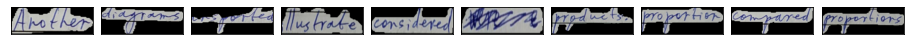

tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
predict is ready
{'CER': 1.1022167487684729}



In [ ]:
get_image_cer('6_1_eng.jpg')

In [ ]:
path = 'data/train_segmentation/images'

sum = 0
right = 0
for image_name in tqdm(os.listdir(path)[:]):
  real = 'en' if 'eng' in image_name else 'ru'
  img = cv2.imread(os.path.join(path, image_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred = pipeline_model(img, True)
  sum += 1
  right += pred == real
  if pred != real:
    print(image_name, real)

print()
print(right, sum)

 18%|█▊        | 164/932 [10:14<51:34,  4.03s/it]

6_1_eng.jpg en


 38%|███▊      | 356/932 [22:05<34:01,  3.54s/it]

51_0.jpg ru


 86%|████████▌ | 801/932 [49:45<08:14,  3.77s/it]

6_0_eng.jpg en


100%|██████████| 932/932 [57:54<00:00,  3.73s/it]


929 932


In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

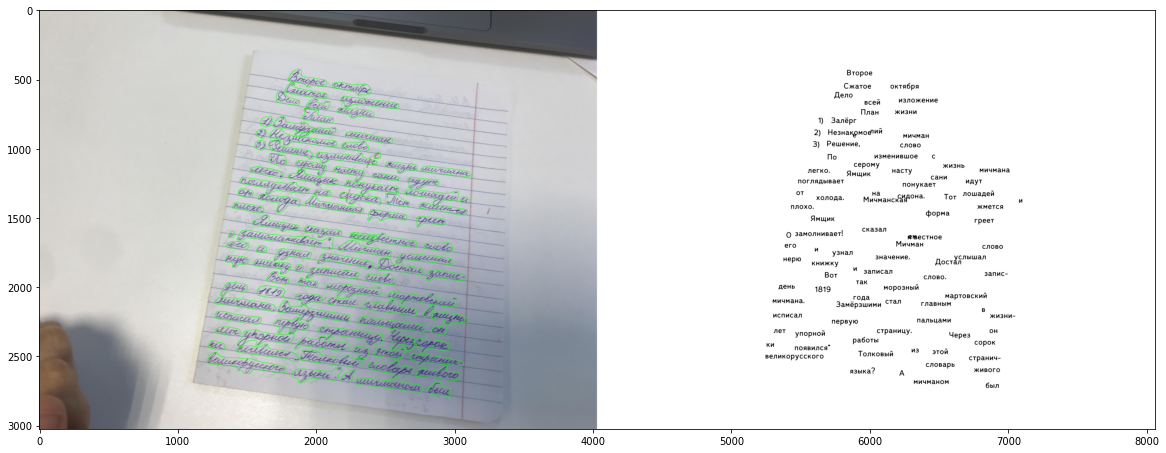

In [ ]:
output = pipeline_model(img)
vis = get_image_visualization(img, output, os.path.join(data_dir, 'font.otf'))

plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.show()

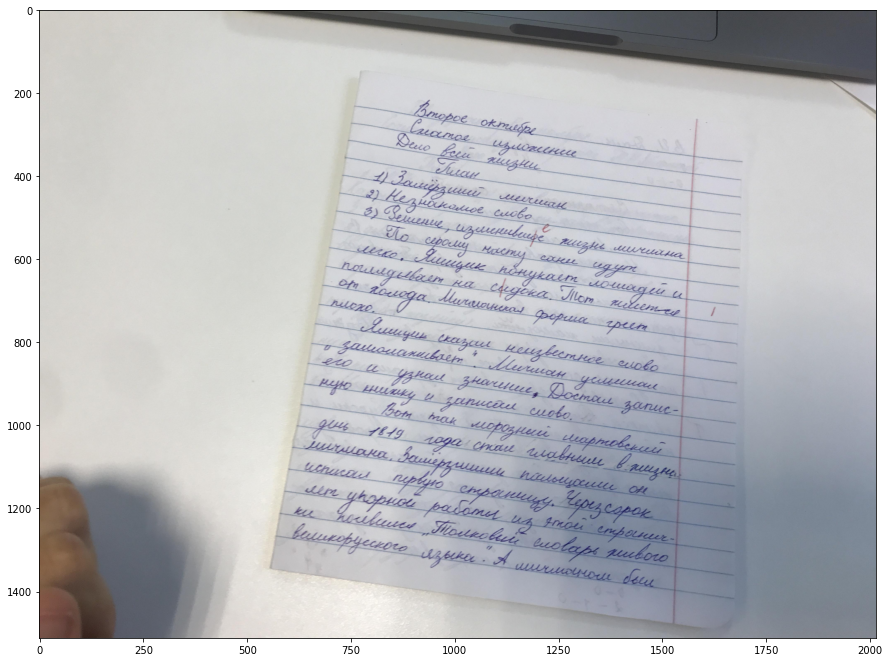

In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)(image=img)['image']

plt.figure(figsize=(15, 15))
plt.imshow(img)

# Save predictions from dataset

In [ ]:
# Путь к json'у с разметкой
DATA_JSON_PATH = 'data/train_segmentation/annotations_val.json'

# Папка с картинками тетрадей
IMAGE_ROOT = 'data/train_segmentation/images/'

# Файл для сохранения предсказаний пайплайна. Один json
SAVE_PATH = os.path.join(project_dir, 'prediction.json')

In [ ]:
with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

pred_data = {}

In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

100%|██████████| 94/94 [23:29<00:00, 15.00s/it]


In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

100%|██████████| 94/94 [14:51<00:00,  9.49s/it]


In [ ]:
with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

In [ ]:
#small
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1509543789153041}


In [ ]:
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.17972025929758892}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1522985675333629}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.27107049797544236}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1522985675333629}


In [ ]:
# detectoRS + en_ocr + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json